## functions

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import os
import gc

import addict
import lightgbm as lgb

def save_dataframe(path, dataframe):
    np.save(path + ".data", dataframe.values)
    np.save(path + ".header", dataframe.columns)


def load_dataframe(path):
    data = np.load(path + ".data.npy")
    header = np.load(path + ".header.npy")
    return pd.DataFrame(data=data, columns=header)


def save_dataframe32(path, dataframe, keep=[]):
    col64 = [col_ for col_ in dataframe.columns if col_ in keep]
    col32 = [col_ for col_ in dataframe.columns if col_ not in keep]
    dataframe64 = dataframe[col64]
    dataframe32 = dataframe[col32]
    np.save(path + ".data64", dataframe64.values)
    np.save(path + ".header64", col64)
    np.save(path + ".data32", dataframe32.values.astype(np.float32))
    np.save(path + ".header32", col32)


def load_dataframe32(path, nrows=None):
    path_data32 = path + ".data32.npy"
    path_header32 = path + ".header32.npy"
    path_data64 = path + ".data64.npy"
    path_header64 = path + ".header64.npy"
    result = pd.DataFrame()
    if os.path.exists(path_data32):
        data32 = np.load(path_data32)
        header32 = np.load(path_header32)
        df32 = pd.DataFrame(data=data32, columns=header32)
        result = pd.concat([result, df32], axis=1)
    if os.path.exists(path_data64):
        data64 = np.load(path_data64)
        header64 = np.load(path_header64)
        df64 = pd.DataFrame(data=data64, columns=header64)
        result = pd.concat([result, df64], axis=1)
    if nrows and nrows > 0:
        return result.head(nrows)
    return result

In [4]:
from sklearn.metrics import roc_auc_score

In [5]:
def replace_nan(X):
    X = X.copy()
    X[np.isnan(X)] = 0
    X[X == np.Inf] = X[X != np.Inf].max()
    X[X == -np.Inf] = X[X != -np.Inf].min()
    # print(X.shape, X.max(), X.min())
    return X

## check data

In [ ]:
# nrows = None  
nrows = None

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
train_app = load_dataframe32("./bindata/application_train")
auc_valid_stack = []
pred_valid_stack = []
pred_test_stack = []

for i in range(5):
    train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

    train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3
    
    train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
    valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
    test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)
    
    if i == 0:
        train_data_fn = train_data_fn.replace("246009", "246008")
        valid_data_fn = valid_data_fn.replace("61502", "61503")
    
    gc.collect()

    train_idx = np.load(train_idx_fn)
    valid_idx = np.load(valid_idx_fn)
    
    if nrows:
        train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

    train_data = load_dataframe32(train_data_fn, nrows)
    valid_data = load_dataframe32(valid_data_fn, nrows)
    test_data = load_dataframe32(test_data_fn, nrows)
    gc.collect()
    
    X_train = train_data.values
    X_valid = valid_data.values
    X_test = test_data.values
    y_train = train_app.loc[train_idx].TARGET
    y_valid = train_app.loc[valid_idx].TARGET
    
    print(train_idx_fn, valid_idx_fn)
    print(train_idx.shape, valid_idx.shape)
    print(train_data_fn, train_data.shape)
    print(valid_data_fn, valid_data.shape)
    print(test_data_fn, test_data.shape)
    
    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)
    print(X_test.shape)
    

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
(246008, 1174) (246008,)
(61503, 1174) (61503,)
(48744, 1174)
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_4 (246009, 1174)
./neptune-features/data_61502_1174_5 (61502, 1174)
./neptune-features/data_48744_1174_7 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)
./neptune-features/train_idx_2.npy ./neptune-features/valid_idx_2.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_8 (246009, 1174)
./neptune-features/data_61502_1174_9 (61502, 1174)
./neptune-features/data_48744_1174_11 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)
./neptune-features/train_idx_3.npy ./neptune-features/valid_idx_3.npy
(246009,) (

## lightgbm

In [6]:
lgb_params = addict.Dict()
lgb_params.boosting_type = "gbdt"
lgb_params.objective = "binary"
lgb_params.metric = "auc"
lgb_params.learning_rate = 0.02
lgb_params.max_bin = 300
lgb_params.max_depth = -1
lgb_params.num_leaves = 42 # 30
lgb_params.min_child_samples = 70
lgb_params.subsample = 1.0
lgb_params.subsample_freq = 1
lgb_params.colsample_bytree = 0.03 # .05
lgb_params.min_gain_to_split = 0.5
lgb_params.reg_lambda = 100
lgb_params.reg_alpha = 0.0
lgb_params.scale_pos_weight = 1
lgb_params.is_unbalance = False

In [7]:
# nrows = None  
nrows = None

features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
train_app = load_dataframe32("./bindata/application_train")
auc_valid_stack = []
pred_valid_stack = []
pred_test_stack = []

for i in range(5):
    train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
    valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

    train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3
    
    train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
    valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
    test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)
    
    if i == 0:
        train_data_fn = train_data_fn.replace("246009", "246008")
        valid_data_fn = valid_data_fn.replace("61502", "61503")
    
    gc.collect()

    train_idx = np.load(train_idx_fn)
    valid_idx = np.load(valid_idx_fn)
    
    if nrows:
        train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

    train_data = load_dataframe32(train_data_fn, nrows)
    valid_data = load_dataframe32(valid_data_fn, nrows)
    test_data = load_dataframe32(test_data_fn, nrows)
    gc.collect()
    
    X_train = replace_nan(train_data.values)
    X_valid = replace_nan(valid_data.values)
    X_test = replace_nan(test_data.values)
    y_train = train_app.loc[train_idx].TARGET
    y_valid = train_app.loc[valid_idx].TARGET
    
    print(train_idx_fn, valid_idx_fn)
    print(train_idx.shape, valid_idx.shape)
    print(train_data_fn, train_data.shape)
    print(valid_data_fn, valid_data.shape)
    print(test_data_fn, test_data.shape)
    
    print(X_train.shape, y_train.shape)
    print(X_valid.shape, y_valid.shape)
    print(X_test.shape)
    
    lgb_data_train = lgb.Dataset(data=X_train, label=y_train)
    lgb_data_valid = lgb.Dataset(data=X_valid, label=y_valid)
    
    estimator = lgb.train(
        lgb_params,
        lgb_data_train,
        valid_sets=[lgb_data_train, lgb_data_valid],
        valid_names=["data_train", "data_valid"],
        num_boost_round=5000,
        early_stopping_rounds=100,
        verbose_eval=100
    )
    
    pred_valid = estimator.predict(X_valid)
    pred_valid_stack.append(pred_valid)
    
    auc = roc_auc_score(y_valid, pred_valid)
    auc_valid_stack.append(auc)
    print("fold-{},auc:{}".format(i, auc))

    pred_test = estimator.predict(X_test)
    pred_test_stack.append(pred_test)
    
print("kfold-auc, avg:{:.4}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
(246008, 1174) (246008,)
(61503, 1174) (61503,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.772002	data_valid's auc: 0.76453
[200]	data_train's auc: 0.786168	data_valid's auc: 0.775193
[300]	data_train's auc: 0.796615	data_valid's auc: 0.781439
[400]	data_train's auc: 0.804924	data_valid's auc: 0.785467
[500]	data_train's auc: 0.812462	data_valid's auc: 0.788121
[600]	data_train's auc: 0.819038	data_valid's auc: 0.790103
[700]	data_train's auc: 0.825218	data_valid's auc: 0.791795
[800]	data_train's auc: 0.830876	data_valid's auc: 0.793042
[900]	data_train's auc: 0.836242	data_valid's auc: 0.794114
[1000]	data_train's auc: 0.841303	data_valid's auc: 0.795184
[1100]	data_train's auc: 0.8460

[100]	data_train's auc: 0.773893	data_valid's auc: 0.760669
[200]	data_train's auc: 0.788092	data_valid's auc: 0.769445
[300]	data_train's auc: 0.798374	data_valid's auc: 0.774596
[400]	data_train's auc: 0.806617	data_valid's auc: 0.778111
[500]	data_train's auc: 0.81379	data_valid's auc: 0.78068
[600]	data_train's auc: 0.820343	data_valid's auc: 0.782612
[700]	data_train's auc: 0.826318	data_valid's auc: 0.784161
[800]	data_train's auc: 0.831948	data_valid's auc: 0.785447
[900]	data_train's auc: 0.837249	data_valid's auc: 0.786442
[1000]	data_train's auc: 0.842157	data_valid's auc: 0.787507
[1100]	data_train's auc: 0.846875	data_valid's auc: 0.788234
[1200]	data_train's auc: 0.851282	data_valid's auc: 0.788865
[1300]	data_train's auc: 0.855569	data_valid's auc: 0.789501
[1400]	data_train's auc: 0.859658	data_valid's auc: 0.789996
[1500]	data_train's auc: 0.863588	data_valid's auc: 0.790354
[1600]	data_train's auc: 0.867361	data_valid's auc: 0.79065
[1700]	data_train's auc: 0.87089	dat

## lightgbm-reorder

In [45]:
def train_cv_pred(seed=0, dev_mode=False):
    print("seed", seed)
    lgb_params = addict.Dict()
    lgb_params.boosting_type = "gbdt"
    lgb_params.objective = "binary"
    lgb_params.metric = "auc"
    lgb_params.learning_rate = 0.02
    lgb_params.max_bin = 300
    lgb_params.max_depth = -1
    lgb_params.num_leaves = 30
    lgb_params.min_child_samples = 70
    lgb_params.subsample = 1.0
    lgb_params.subsample_freq = 1
    lgb_params.colsample_bytree = 0.05
    lgb_params.min_gain_to_split = 0.5
    lgb_params.reg_lambda = 100
    lgb_params.reg_alpha = 0.0
    lgb_params.scale_pos_weight = 1
    lgb_params.is_unbalance = False
    
    nrows = 1000 if dev_mode else None

    features = list(np.load('./neptune-features/features_246008_1174_0.npy'))
    np.random.seed(seed)
    np.random.shuffle(features)
    print(features[:5])
    train_app = load_dataframe32("./bindata/application_train")
    auc_valid_stack = []
    pred_valid_stack = []
    pred_test_stack = []

    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()

        train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)

        if nrows:
            train_idx, valid_idx = train_idx[:nrows].copy(), valid_idx[:nrows].copy()

        train_data = load_dataframe32(train_data_fn, nrows)
        valid_data = load_dataframe32(valid_data_fn, nrows)
        test_data = load_dataframe32(test_data_fn, nrows)
        gc.collect()

        X_train = train_data[features].values
        X_valid = valid_data[features].values
        X_test = test_data[features].values
        y_train = train_app.loc[train_idx].TARGET
        y_valid = train_app.loc[valid_idx].TARGET

        print(train_idx_fn, valid_idx_fn)
        print(train_idx.shape, valid_idx.shape)
        print(train_data_fn, train_data.shape)
        print(valid_data_fn, valid_data.shape)
        print(test_data_fn, test_data.shape)

        print(X_train.shape, y_train.shape)
        print(X_valid.shape, y_valid.shape)
        print(X_test.shape)

        lgb_data_train = lgb.Dataset(data=X_train, label=y_train)
        lgb_data_valid = lgb.Dataset(data=X_valid, label=y_valid)

        estimator = lgb.train(
            lgb_params,
            lgb_data_train,
            valid_sets=[lgb_data_train, lgb_data_valid],
            valid_names=["data_train", "data_valid"],
            num_boost_round=5000,
            early_stopping_rounds=100,
            verbose_eval=100
        )

        pred_valid = estimator.predict(X_valid)
        pred_valid_stack.append(pred_valid)

        auc = roc_auc_score(y_valid, pred_valid)
        auc_valid_stack.append(auc)
        print("fold-{},auc:{}".format(i, auc))

        pred_test = estimator.predict(X_test)
        pred_test_stack.append(pred_test)

    print("kfold-auc, avg:{:.4}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))
    
    return pred_valid_stack, pred_test_stack, train_app

In [6]:
train_cv_pred()

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(1000,) (1000,)
./neptune-features/data_246008_1174_0 (1000, 1174)
./neptune-features/data_61503_1174_1 (1000, 1174)
./neptune-features/data_48744_1174_3 (1000, 1174)
(1000, 1174) (1000,)
(1000, 1174) (1000,)
(1000, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.869093	data_valid's auc: 0.674711
Early stopping, best iteration is:
[10]	data_train's auc: 0.857994	data_valid's auc: 0.697335
fold-0,auc:0.6973347937203358
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(1000,) (1000,)
./neptune-features/data_246009_1174_4 (1000, 1174)
./neptune-features/data_61502_1174_5 (1000, 1174)
./neptune-features/data_48744_1174_7 (1000, 1174)
(1000, 1174) (1000,)
(1000, 1174) (1000,)
(1000, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.870064	data_valid's auc: 0.744908
[200]	data_train's auc: 0.885457	data_valid's 

In [8]:
train_cv_pred()

['NAME_EDUCATION_TYPE_OCCUPATION_TYPE_APARTMENTS_AVG_mean_abs_diff', 'last_5by20_fraction_NUM_INSTALMENT_VERSION_sum', 'last_loan_SK_DPD_DEF_mean', 'last_5by20_fraction_installment_paid_over_mean', 'last_10by50_fraction_installment_paid_over_amount_kurt']
./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(1000,) (1000,)
./neptune-features/data_246008_1174_0 (1000, 1174)
./neptune-features/data_61503_1174_1 (1000, 1174)
./neptune-features/data_48744_1174_3 (1000, 1174)
(1000, 1174) (1000,)
(1000, 1174) (1000,)
(1000, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.875559	data_valid's auc: 0.68292
Early stopping, best iteration is:
[93]	data_train's auc: 0.873461	data_valid's auc: 0.685475
fold-0,auc:0.6854754440961337
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(1000,) (1000,)
./neptune-features/data_246009_1174_4 (1000, 1174)
./neptune-features/data_61502_1174_5 (1000, 1174)
./neptune-features/

## save oof & submission

In [8]:
def calculate_rank(predictions):
    rank = (1 + pd.Series(predictions).rank().values) / (predictions.shape[0] + 1)
    return rank

def save_submission(pred_valid_stack, pred_test_stack, train_app, seed=0, exp="044"):
    pred_fn = "./result/submission-{}-lgb-seed-{}.csv".format(exp, seed)
    oof_fn = "./oof-result/oof-{}-lgb-seed-{}.csv".format(exp, seed)
    pred_target = sum([calculate_rank(p_) for p_ in pred_test_stack]) / 5

    pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
    pred_sample["TARGET"] = pred_target
    pred_sample.to_csv(pred_fn, index=False)
    print("save:", pred_fn)

    oof_pred = np.zeros(train_app.shape[0])
    for i in range(5):
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)
        valid_idx = np.load(valid_idx_fn)
        oof_pred[valid_idx] = pred_valid_stack[i]

    oof_df = train_app[["SK_ID_CURR"]].copy()
    oof_df["SK_ID_CURR"] = oof_df.SK_ID_CURR.astype("int")
    oof_df["oof_pred"] = oof_pred
    oof_df.to_csv(oof_fn, index=False)
    print("save:", oof_fn)

In [9]:
save_submission(pred_valid_stack, pred_test_stack, train_app, seed=0)

save: ./result/submission-044-lgb-seed-0.csv
save: ./oof-result/oof-044-lgb-seed-0.csv


## lightgbm-reorder loop

In [22]:
seed = 0
pred_valid_stack, pred_test_stack, train_app = train_cv_pred(seed=seed)
save_submission(pred_valid_stack, pred_test_stack, train_app, seed=seed)

seed 0
['NAME_EDUCATION_TYPE_OCCUPATION_TYPE_APARTMENTS_AVG_mean_abs_diff', 'last_5by20_fraction_NUM_INSTALMENT_VERSION_sum', 'last_loan_SK_DPD_DEF_mean', 'last_5by20_fraction_installment_paid_over_mean', 'last_10by50_fraction_installment_paid_over_amount_kurt']
./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
(246008, 1174) (246008,)
(61503, 1174) (61503,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.767697	data_valid's auc: 0.762411
[200]	data_train's auc: 0.78424	data_valid's auc: 0.775988
[300]	data_train's auc: 0.795199	data_valid's auc: 0.783312
[400]	data_train's auc: 0.803116	data_valid's auc: 0.787259
[500]	data_train's auc: 0.80984	data_valid's auc: 0.790032
[600]	data_train's auc: 0.815688	data_valid's auc: 0.791963
[700]	data

fold-3,auc:0.7944589219180246
./neptune-features/train_idx_4.npy ./neptune-features/valid_idx_4.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_16 (246009, 1174)
./neptune-features/data_61502_1174_17 (61502, 1174)
./neptune-features/data_48744_1174_19 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.769537	data_valid's auc: 0.75838
[200]	data_train's auc: 0.786626	data_valid's auc: 0.770144
[300]	data_train's auc: 0.797208	data_valid's auc: 0.776268
[400]	data_train's auc: 0.805092	data_valid's auc: 0.779989
[500]	data_train's auc: 0.811758	data_valid's auc: 0.782519
[600]	data_train's auc: 0.817569	data_valid's auc: 0.784435
[700]	data_train's auc: 0.822837	data_valid's auc: 0.785933
[800]	data_train's auc: 0.827761	data_valid's auc: 0.787144
[900]	data_train's auc: 0.832225	data_valid's auc: 0.788159
[1000]	data_train's auc: 0.836387	data_valid's auc: 0.78890

NameError: name 'train_app' is not defined

In [28]:
train_app = load_dataframe32("./bindata/application_train")
save_submission(pred_valid_stack, pred_test_stack, train_app, seed=seed)

save: ./result/submission-031-lgb-seed-0.csv
save: ./oof-result/oof-031-lgb-seed-0.csv


In [41]:
train_app = load_dataframe32("./bindata/application_train")
save_submission(pred_valid_stack, pred_test_stack, train_app, seed=seed)

save: ./result/submission-031-lgb-seed-1.csv
save: ./oof-result/oof-031-lgb-seed-1.csv


In [43]:
train_app = load_dataframe32("./bindata/application_train")
save_submission(pred_valid_stack, pred_test_stack, train_app, seed=seed)

save: ./result/submission-031-lgb-seed-2.csv
save: ./oof-result/oof-031-lgb-seed-2.csv


In [46]:
for seed in range(3, 10):
    pred_valid_stack, pred_test_stack, train_app = train_cv_pred(seed=seed)
    save_submission(pred_valid_stack, pred_test_stack, train_app, seed=seed)
    gc.collect()

seed 3
['bureau_SK_ID_CURR_count_CREDIT_TYPE', 'NAME_EDUCATION_TYPE_OCCUPATION_TYPE_REG_CITY_NOT_WORK_CITY_ELEVATORS_AVG_mean_abs_diff', 'NAME_FAMILY_STATUS_CODE_GENDER_CNT_FAM_MEMBERS_mean_abs_diff', 'NAME_EDUCATION_TYPE_CODE_GENDER_DAYS_BIRTH_max_diff', 'last_10by100_fraction_NUM_INSTALMENT_VERSION_skew']
./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
(246008, 1174) (246008,)
(61503, 1174) (61503,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.768095	data_valid's auc: 0.762219
[200]	data_train's auc: 0.784153	data_valid's auc: 0.77545
[300]	data_train's auc: 0.794501	data_valid's auc: 0.781944
[400]	data_train's auc: 0.802764	data_valid's auc: 0.786385
[500]	data_train's auc: 0.809584	data_valid's auc: 0.789399
[600]	data_train's auc:

Early stopping, best iteration is:
[2523]	data_train's auc: 0.881304	data_valid's auc: 0.794186
fold-3,auc:0.7941860779315513
./neptune-features/train_idx_4.npy ./neptune-features/valid_idx_4.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_16 (246009, 1174)
./neptune-features/data_61502_1174_17 (61502, 1174)
./neptune-features/data_48744_1174_19 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.769694	data_valid's auc: 0.759074
[200]	data_train's auc: 0.785907	data_valid's auc: 0.770145
[300]	data_train's auc: 0.796029	data_valid's auc: 0.775837
[400]	data_train's auc: 0.804367	data_valid's auc: 0.779913
[500]	data_train's auc: 0.811183	data_valid's auc: 0.782789
[600]	data_train's auc: 0.816969	data_valid's auc: 0.784713
[700]	data_train's auc: 0.82241	data_valid's auc: 0.786338
[800]	data_train's auc: 0.827416	data_valid's auc: 0.787628
[900]	data_train's auc:

fold-2,auc:0.7928680735789221
./neptune-features/train_idx_3.npy ./neptune-features/valid_idx_3.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_12 (246009, 1174)
./neptune-features/data_61502_1174_13 (61502, 1174)
./neptune-features/data_48744_1174_15 (48744, 1174)
(246009, 1174) (246009,)
(61502, 1174) (61502,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.769842	data_valid's auc: 0.756693
[200]	data_train's auc: 0.785926	data_valid's auc: 0.768989
[300]	data_train's auc: 0.796232	data_valid's auc: 0.776097
[400]	data_train's auc: 0.804131	data_valid's auc: 0.780591
[500]	data_train's auc: 0.810833	data_valid's auc: 0.783897
[600]	data_train's auc: 0.816752	data_valid's auc: 0.786413
[700]	data_train's auc: 0.822103	data_valid's auc: 0.788207
[800]	data_train's auc: 0.826952	data_valid's auc: 0.789539
[900]	data_train's auc: 0.831546	data_valid's auc: 0.790449
[1000]	data_train's auc: 0.835849	data_valid's auc: 0.7912

Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.770869	data_valid's auc: 0.756584
[200]	data_train's auc: 0.787219	data_valid's auc: 0.768789
[300]	data_train's auc: 0.797444	data_valid's auc: 0.775496
[400]	data_train's auc: 0.805265	data_valid's auc: 0.779537
[500]	data_train's auc: 0.811872	data_valid's auc: 0.782563
[600]	data_train's auc: 0.817708	data_valid's auc: 0.784674
[700]	data_train's auc: 0.822931	data_valid's auc: 0.78628
[800]	data_train's auc: 0.827772	data_valid's auc: 0.787784
[900]	data_train's auc: 0.832235	data_valid's auc: 0.788758
[1000]	data_train's auc: 0.836468	data_valid's auc: 0.789682
[1100]	data_train's auc: 0.840338	data_valid's auc: 0.790481
[1200]	data_train's auc: 0.844086	data_valid's auc: 0.79106
[1300]	data_train's auc: 0.847597	data_valid's auc: 0.791515
[1400]	data_train's auc: 0.850962	data_valid's auc: 0.791907
[1500]	data_train's auc: 0.854137	data_valid's auc: 0.792174
[1600]	data_train's auc: 0.857181

[300]	data_train's auc: 0.796751	data_valid's auc: 0.775072
[400]	data_train's auc: 0.80453	data_valid's auc: 0.778854
[500]	data_train's auc: 0.8114	data_valid's auc: 0.781698
[600]	data_train's auc: 0.817346	data_valid's auc: 0.783746
[700]	data_train's auc: 0.822768	data_valid's auc: 0.785318
[800]	data_train's auc: 0.827704	data_valid's auc: 0.78653
[900]	data_train's auc: 0.832323	data_valid's auc: 0.787542
[1000]	data_train's auc: 0.836575	data_valid's auc: 0.788309
[1100]	data_train's auc: 0.840616	data_valid's auc: 0.78887
[1200]	data_train's auc: 0.844395	data_valid's auc: 0.789282
[1300]	data_train's auc: 0.847901	data_valid's auc: 0.78964
[1400]	data_train's auc: 0.851219	data_valid's auc: 0.790032
[1500]	data_train's auc: 0.854568	data_valid's auc: 0.790494
[1600]	data_train's auc: 0.857645	data_valid's auc: 0.790765
[1700]	data_train's auc: 0.860597	data_valid's auc: 0.790998
[1800]	data_train's auc: 0.863464	data_valid's auc: 0.791127
[1900]	data_train's auc: 0.866191	dat

[200]	data_train's auc: 0.784476	data_valid's auc: 0.776336
[300]	data_train's auc: 0.794918	data_valid's auc: 0.783052
[400]	data_train's auc: 0.802879	data_valid's auc: 0.787184
[500]	data_train's auc: 0.809721	data_valid's auc: 0.789965
[600]	data_train's auc: 0.815656	data_valid's auc: 0.791946
[700]	data_train's auc: 0.821166	data_valid's auc: 0.793407
[800]	data_train's auc: 0.826188	data_valid's auc: 0.794559
[900]	data_train's auc: 0.830786	data_valid's auc: 0.795535
[1000]	data_train's auc: 0.835044	data_valid's auc: 0.796279
[1100]	data_train's auc: 0.839091	data_valid's auc: 0.796841
[1200]	data_train's auc: 0.842954	data_valid's auc: 0.797296
[1300]	data_train's auc: 0.846654	data_valid's auc: 0.797696
[1400]	data_train's auc: 0.850055	data_valid's auc: 0.798054
[1500]	data_train's auc: 0.853365	data_valid's auc: 0.798324
[1600]	data_train's auc: 0.856609	data_valid's auc: 0.798618
[1700]	data_train's auc: 0.859596	data_valid's auc: 0.798824
[1800]	data_train's auc: 0.86248

[500]	data_train's auc: 0.811221	data_valid's auc: 0.781859
[600]	data_train's auc: 0.817027	data_valid's auc: 0.783898
[700]	data_train's auc: 0.822384	data_valid's auc: 0.785586
[800]	data_train's auc: 0.827345	data_valid's auc: 0.786961
[900]	data_train's auc: 0.831882	data_valid's auc: 0.787797
[1000]	data_train's auc: 0.836102	data_valid's auc: 0.788406
[1100]	data_train's auc: 0.84007	data_valid's auc: 0.788993
[1200]	data_train's auc: 0.843906	data_valid's auc: 0.789463
[1300]	data_train's auc: 0.847423	data_valid's auc: 0.789868
[1400]	data_train's auc: 0.850827	data_valid's auc: 0.790276
[1500]	data_train's auc: 0.854013	data_valid's auc: 0.790724
[1600]	data_train's auc: 0.857127	data_valid's auc: 0.79096
[1700]	data_train's auc: 0.860105	data_valid's auc: 0.791144
[1800]	data_train's auc: 0.862972	data_valid's auc: 0.791287
[1900]	data_train's auc: 0.865836	data_valid's auc: 0.791484
[2000]	data_train's auc: 0.868518	data_valid's auc: 0.791726
[2100]	data_train's auc: 0.8711

[300]	data_train's auc: 0.79648	data_valid's auc: 0.776562
[400]	data_train's auc: 0.804222	data_valid's auc: 0.780873
[500]	data_train's auc: 0.810817	data_valid's auc: 0.78387
[600]	data_train's auc: 0.816571	data_valid's auc: 0.786107
[700]	data_train's auc: 0.821919	data_valid's auc: 0.78792
[800]	data_train's auc: 0.82679	data_valid's auc: 0.789301
[900]	data_train's auc: 0.831403	data_valid's auc: 0.790351
[1000]	data_train's auc: 0.835622	data_valid's auc: 0.791131
[1100]	data_train's auc: 0.839604	data_valid's auc: 0.791604
[1200]	data_train's auc: 0.843418	data_valid's auc: 0.792081
[1300]	data_train's auc: 0.846966	data_valid's auc: 0.792538
[1400]	data_train's auc: 0.850444	data_valid's auc: 0.792889
[1500]	data_train's auc: 0.853729	data_valid's auc: 0.793215
[1600]	data_train's auc: 0.856887	data_valid's auc: 0.7935
[1700]	data_train's auc: 0.859935	data_valid's auc: 0.793738
[1800]	data_train's auc: 0.862853	data_valid's auc: 0.793917
[1900]	data_train's auc: 0.865629	dat

[600]	data_train's auc: 0.817439	data_valid's auc: 0.784334
[700]	data_train's auc: 0.822758	data_valid's auc: 0.785948
[800]	data_train's auc: 0.827693	data_valid's auc: 0.787301
[900]	data_train's auc: 0.832239	data_valid's auc: 0.788457
[1000]	data_train's auc: 0.836435	data_valid's auc: 0.789302
[1100]	data_train's auc: 0.840385	data_valid's auc: 0.789967
[1200]	data_train's auc: 0.844085	data_valid's auc: 0.79044
[1300]	data_train's auc: 0.847568	data_valid's auc: 0.79097
[1400]	data_train's auc: 0.850965	data_valid's auc: 0.791238
[1500]	data_train's auc: 0.854225	data_valid's auc: 0.791533
[1600]	data_train's auc: 0.857275	data_valid's auc: 0.791693
[1700]	data_train's auc: 0.860156	data_valid's auc: 0.791776
[1800]	data_train's auc: 0.863061	data_valid's auc: 0.791963
[1900]	data_train's auc: 0.865829	data_valid's auc: 0.792114
[2000]	data_train's auc: 0.868458	data_valid's auc: 0.792177
[2100]	data_train's auc: 0.871	data_valid's auc: 0.79228
[2200]	data_train's auc: 0.873418	

In [72]:
for seed in range(10, 30):
    pred_valid_stack, pred_test_stack, train_app = train_cv_pred(seed=seed)
    save_submission(pred_valid_stack, pred_test_stack, train_app, seed=seed)
    gc.collect()

seed 10
['NAME_FAMILY_STATUS_CODE_GENDER_DAYS_EMPLOYED_mean_diff', 'NAME_EDUCATION_TYPE_CODE_GENDER_CNT_CHILDREN_mean_abs_diff', 'NAME_FAMILY_STATUS_NAME_EDUCATION_TYPE_OWN_CAR_AGE_mean_abs_diff', 'last_50_NUM_INSTALMENT_VERSION_median', 'credit_card_balance_SK_ID_CURR_mean_AMT_DRAWINGS_ATM_CURRENT']
./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
(246008, 1174) (246008,)
(61503, 1174) (61503,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.767427	data_valid's auc: 0.761778
[200]	data_train's auc: 0.784315	data_valid's auc: 0.775865
[300]	data_train's auc: 0.794844	data_valid's auc: 0.782603
[400]	data_train's auc: 0.802674	data_valid's auc: 0.786811
[500]	data_train's auc: 0.809597	data_valid's auc: 0.78995
[600]	data_train's auc: 0.8157

Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.769382	data_valid's auc: 0.75847
[200]	data_train's auc: 0.786171	data_valid's auc: 0.770289
[300]	data_train's auc: 0.796444	data_valid's auc: 0.776237
[400]	data_train's auc: 0.804243	data_valid's auc: 0.779781
[500]	data_train's auc: 0.811129	data_valid's auc: 0.782728
[600]	data_train's auc: 0.817055	data_valid's auc: 0.784797
[700]	data_train's auc: 0.822302	data_valid's auc: 0.786463
[800]	data_train's auc: 0.827222	data_valid's auc: 0.787901
[900]	data_train's auc: 0.831796	data_valid's auc: 0.788977
[1000]	data_train's auc: 0.836044	data_valid's auc: 0.789812
[1100]	data_train's auc: 0.840035	data_valid's auc: 0.790453
[1200]	data_train's auc: 0.843829	data_valid's auc: 0.790982
[1300]	data_train's auc: 0.847469	data_valid's auc: 0.791493
[1400]	data_train's auc: 0.850871	data_valid's auc: 0.791765
[1500]	data_train's auc: 0.854048	data_valid's auc: 0.79203
[1600]	data_train's auc: 0.857218

[600]	data_train's auc: 0.816616	data_valid's auc: 0.785855
[700]	data_train's auc: 0.821864	data_valid's auc: 0.787714
[800]	data_train's auc: 0.826723	data_valid's auc: 0.789218
[900]	data_train's auc: 0.831461	data_valid's auc: 0.790381
[1000]	data_train's auc: 0.835765	data_valid's auc: 0.791251
[1100]	data_train's auc: 0.839829	data_valid's auc: 0.791872
[1200]	data_train's auc: 0.843587	data_valid's auc: 0.792384
[1300]	data_train's auc: 0.847128	data_valid's auc: 0.792819
[1400]	data_train's auc: 0.850624	data_valid's auc: 0.793251
[1500]	data_train's auc: 0.853891	data_valid's auc: 0.793369
[1600]	data_train's auc: 0.857033	data_valid's auc: 0.793561
[1700]	data_train's auc: 0.86015	data_valid's auc: 0.793774
[1800]	data_train's auc: 0.863107	data_valid's auc: 0.793982
[1900]	data_train's auc: 0.865949	data_valid's auc: 0.794057
[2000]	data_train's auc: 0.86866	data_valid's auc: 0.794167
Early stopping, best iteration is:
[1977]	data_train's auc: 0.868041	data_valid's auc: 0.79

[1100]	data_train's auc: 0.840504	data_valid's auc: 0.790175
[1200]	data_train's auc: 0.84421	data_valid's auc: 0.790738
[1300]	data_train's auc: 0.847742	data_valid's auc: 0.791134
[1400]	data_train's auc: 0.851062	data_valid's auc: 0.791474
[1500]	data_train's auc: 0.854274	data_valid's auc: 0.791762
[1600]	data_train's auc: 0.857429	data_valid's auc: 0.791937
[1700]	data_train's auc: 0.860379	data_valid's auc: 0.79205
[1800]	data_train's auc: 0.863164	data_valid's auc: 0.792233
[1900]	data_train's auc: 0.865894	data_valid's auc: 0.79232
[2000]	data_train's auc: 0.868529	data_valid's auc: 0.792416
[2100]	data_train's auc: 0.871104	data_valid's auc: 0.792555
[2200]	data_train's auc: 0.873569	data_valid's auc: 0.792711
[2300]	data_train's auc: 0.87599	data_valid's auc: 0.792783
[2400]	data_train's auc: 0.878319	data_valid's auc: 0.792771
Early stopping, best iteration is:
[2306]	data_train's auc: 0.876138	data_valid's auc: 0.792807
fold-2,auc:0.7928071451074622
./neptune-features/train

[600]	data_train's auc: 0.817556	data_valid's auc: 0.784633
[700]	data_train's auc: 0.822951	data_valid's auc: 0.786213
[800]	data_train's auc: 0.827833	data_valid's auc: 0.787331
[900]	data_train's auc: 0.832558	data_valid's auc: 0.788397
[1000]	data_train's auc: 0.836794	data_valid's auc: 0.789111
[1100]	data_train's auc: 0.840698	data_valid's auc: 0.789684
[1200]	data_train's auc: 0.844421	data_valid's auc: 0.790245
[1300]	data_train's auc: 0.847993	data_valid's auc: 0.790644
[1400]	data_train's auc: 0.85146	data_valid's auc: 0.790937
[1500]	data_train's auc: 0.854671	data_valid's auc: 0.791356
[1600]	data_train's auc: 0.857766	data_valid's auc: 0.79169
[1700]	data_train's auc: 0.860773	data_valid's auc: 0.791954
[1800]	data_train's auc: 0.863656	data_valid's auc: 0.792141
[1900]	data_train's auc: 0.866434	data_valid's auc: 0.792294
[2000]	data_train's auc: 0.86904	data_valid's auc: 0.792485
[2100]	data_train's auc: 0.871626	data_valid's auc: 0.792499
[2200]	data_train's auc: 0.8741

[600]	data_train's auc: 0.815781	data_valid's auc: 0.791939
[700]	data_train's auc: 0.821169	data_valid's auc: 0.793504
[800]	data_train's auc: 0.826212	data_valid's auc: 0.794703
[900]	data_train's auc: 0.830914	data_valid's auc: 0.795635
[1000]	data_train's auc: 0.835413	data_valid's auc: 0.796416
[1100]	data_train's auc: 0.839522	data_valid's auc: 0.797038
[1200]	data_train's auc: 0.843441	data_valid's auc: 0.797495
[1300]	data_train's auc: 0.847204	data_valid's auc: 0.79787
[1400]	data_train's auc: 0.850674	data_valid's auc: 0.798222
[1500]	data_train's auc: 0.854018	data_valid's auc: 0.798523
[1600]	data_train's auc: 0.857224	data_valid's auc: 0.798804
[1700]	data_train's auc: 0.860303	data_valid's auc: 0.798941
[1800]	data_train's auc: 0.863167	data_valid's auc: 0.799128
[1900]	data_train's auc: 0.865926	data_valid's auc: 0.799192
[2000]	data_train's auc: 0.8686	data_valid's auc: 0.799291
[2100]	data_train's auc: 0.87113	data_valid's auc: 0.799336
[2200]	data_train's auc: 0.87370

[600]	data_train's auc: 0.816883	data_valid's auc: 0.783919
[700]	data_train's auc: 0.822207	data_valid's auc: 0.785355
[800]	data_train's auc: 0.827072	data_valid's auc: 0.78667
[900]	data_train's auc: 0.83171	data_valid's auc: 0.787608
[1000]	data_train's auc: 0.836124	data_valid's auc: 0.788516
[1100]	data_train's auc: 0.840099	data_valid's auc: 0.789177
[1200]	data_train's auc: 0.84395	data_valid's auc: 0.789802
[1300]	data_train's auc: 0.847602	data_valid's auc: 0.790254
[1400]	data_train's auc: 0.850938	data_valid's auc: 0.790757
[1500]	data_train's auc: 0.854327	data_valid's auc: 0.791142
[1600]	data_train's auc: 0.857474	data_valid's auc: 0.79138
[1700]	data_train's auc: 0.860435	data_valid's auc: 0.791528
[1800]	data_train's auc: 0.863344	data_valid's auc: 0.791815
[1900]	data_train's auc: 0.866221	data_valid's auc: 0.792021
[2000]	data_train's auc: 0.868815	data_valid's auc: 0.792225
[2100]	data_train's auc: 0.871366	data_valid's auc: 0.792259
Early stopping, best iteration i

[600]	data_train's auc: 0.816467	data_valid's auc: 0.785875
[700]	data_train's auc: 0.821869	data_valid's auc: 0.787819
[800]	data_train's auc: 0.826737	data_valid's auc: 0.789268
[900]	data_train's auc: 0.831297	data_valid's auc: 0.790327
[1000]	data_train's auc: 0.835613	data_valid's auc: 0.791276
[1100]	data_train's auc: 0.839617	data_valid's auc: 0.792027
[1200]	data_train's auc: 0.843411	data_valid's auc: 0.792415
[1300]	data_train's auc: 0.846937	data_valid's auc: 0.792899
[1400]	data_train's auc: 0.850416	data_valid's auc: 0.793289
[1500]	data_train's auc: 0.853625	data_valid's auc: 0.793542
[1600]	data_train's auc: 0.856687	data_valid's auc: 0.793768
[1700]	data_train's auc: 0.859642	data_valid's auc: 0.793914
[1800]	data_train's auc: 0.862472	data_valid's auc: 0.794055
[1900]	data_train's auc: 0.865295	data_valid's auc: 0.794103
[2000]	data_train's auc: 0.867972	data_valid's auc: 0.794217
[2100]	data_train's auc: 0.870604	data_valid's auc: 0.794351
[2200]	data_train's auc: 0.8

[400]	data_train's auc: 0.804854	data_valid's auc: 0.77904
[500]	data_train's auc: 0.811527	data_valid's auc: 0.782032
[600]	data_train's auc: 0.817374	data_valid's auc: 0.784291
[700]	data_train's auc: 0.822726	data_valid's auc: 0.78605
[800]	data_train's auc: 0.827553	data_valid's auc: 0.787281
[900]	data_train's auc: 0.832001	data_valid's auc: 0.788278
[1000]	data_train's auc: 0.836182	data_valid's auc: 0.789146
[1100]	data_train's auc: 0.840133	data_valid's auc: 0.789957
[1200]	data_train's auc: 0.843965	data_valid's auc: 0.790506
[1300]	data_train's auc: 0.847502	data_valid's auc: 0.790938
[1400]	data_train's auc: 0.850908	data_valid's auc: 0.791271
[1500]	data_train's auc: 0.854072	data_valid's auc: 0.791548
[1600]	data_train's auc: 0.857145	data_valid's auc: 0.79181
[1700]	data_train's auc: 0.860172	data_valid's auc: 0.791903
[1800]	data_train's auc: 0.862976	data_valid's auc: 0.791986
[1900]	data_train's auc: 0.865691	data_valid's auc: 0.792103
[2000]	data_train's auc: 0.868311

[500]	data_train's auc: 0.811325	data_valid's auc: 0.782636
[600]	data_train's auc: 0.817343	data_valid's auc: 0.784736
[700]	data_train's auc: 0.8228	data_valid's auc: 0.78643
[800]	data_train's auc: 0.827652	data_valid's auc: 0.787635
[900]	data_train's auc: 0.832133	data_valid's auc: 0.788708
[1000]	data_train's auc: 0.836448	data_valid's auc: 0.789432
[1100]	data_train's auc: 0.840445	data_valid's auc: 0.790076
[1200]	data_train's auc: 0.844252	data_valid's auc: 0.790606
[1300]	data_train's auc: 0.847849	data_valid's auc: 0.790974
[1400]	data_train's auc: 0.851204	data_valid's auc: 0.791288
[1500]	data_train's auc: 0.85454	data_valid's auc: 0.791652
[1600]	data_train's auc: 0.857711	data_valid's auc: 0.791931
[1700]	data_train's auc: 0.860683	data_valid's auc: 0.792276
[1800]	data_train's auc: 0.863543	data_valid's auc: 0.792468
[1900]	data_train's auc: 0.86627	data_valid's auc: 0.792736
[2000]	data_train's auc: 0.869036	data_valid's auc: 0.79287
[2100]	data_train's auc: 0.87163	da

[600]	data_train's auc: 0.815777	data_valid's auc: 0.7918
[700]	data_train's auc: 0.82126	data_valid's auc: 0.793514
[800]	data_train's auc: 0.826298	data_valid's auc: 0.794765
[900]	data_train's auc: 0.831028	data_valid's auc: 0.7958
[1000]	data_train's auc: 0.835391	data_valid's auc: 0.796552
[1100]	data_train's auc: 0.839602	data_valid's auc: 0.797236
[1200]	data_train's auc: 0.843566	data_valid's auc: 0.797708
[1300]	data_train's auc: 0.847225	data_valid's auc: 0.798121
[1400]	data_train's auc: 0.850745	data_valid's auc: 0.798381
[1500]	data_train's auc: 0.85411	data_valid's auc: 0.798614
[1600]	data_train's auc: 0.857243	data_valid's auc: 0.798824
[1700]	data_train's auc: 0.860366	data_valid's auc: 0.799045
[1800]	data_train's auc: 0.863272	data_valid's auc: 0.799172
[1900]	data_train's auc: 0.866183	data_valid's auc: 0.799335
Early stopping, best iteration is:
[1898]	data_train's auc: 0.866126	data_valid's auc: 0.799347
fold-0,auc:0.7993467057260314
./neptune-features/train_idx_1

[1300]	data_train's auc: 0.847294	data_valid's auc: 0.791152
[1400]	data_train's auc: 0.850775	data_valid's auc: 0.791467
[1500]	data_train's auc: 0.854022	data_valid's auc: 0.791777
[1600]	data_train's auc: 0.857203	data_valid's auc: 0.792056
[1700]	data_train's auc: 0.860225	data_valid's auc: 0.792336
[1800]	data_train's auc: 0.863116	data_valid's auc: 0.792571
[1900]	data_train's auc: 0.866002	data_valid's auc: 0.792742
[2000]	data_train's auc: 0.868693	data_valid's auc: 0.792917
[2100]	data_train's auc: 0.871291	data_valid's auc: 0.792991
[2200]	data_train's auc: 0.873751	data_valid's auc: 0.793101
[2300]	data_train's auc: 0.876148	data_valid's auc: 0.793167
[2400]	data_train's auc: 0.878472	data_valid's auc: 0.793224
[2500]	data_train's auc: 0.880792	data_valid's auc: 0.793153
Early stopping, best iteration is:
[2432]	data_train's auc: 0.879239	data_valid's auc: 0.79325
fold-4,auc:0.7932495364682088
kfold-auc, avg:0.7946, std:0.0024
save: ./result/submission-031-lgb-seed-18.csv
sa

[1000]	data_train's auc: 0.835754	data_valid's auc: 0.790984
[1100]	data_train's auc: 0.839727	data_valid's auc: 0.791611
[1200]	data_train's auc: 0.843404	data_valid's auc: 0.792112
[1300]	data_train's auc: 0.847046	data_valid's auc: 0.792595
[1400]	data_train's auc: 0.850564	data_valid's auc: 0.792902
[1500]	data_train's auc: 0.853776	data_valid's auc: 0.793154
[1600]	data_train's auc: 0.856932	data_valid's auc: 0.793432
[1700]	data_train's auc: 0.859881	data_valid's auc: 0.793546
[1800]	data_train's auc: 0.862728	data_valid's auc: 0.793759
[1900]	data_train's auc: 0.865449	data_valid's auc: 0.793823
[2000]	data_train's auc: 0.868197	data_valid's auc: 0.793948
[2100]	data_train's auc: 0.870744	data_valid's auc: 0.794032
[2200]	data_train's auc: 0.873351	data_valid's auc: 0.794097
[2300]	data_train's auc: 0.875803	data_valid's auc: 0.794169
[2400]	data_train's auc: 0.878206	data_valid's auc: 0.794154
[2500]	data_train's auc: 0.880472	data_valid's auc: 0.794218
[2600]	data_train's auc:

[500]	data_train's auc: 0.811275	data_valid's auc: 0.782144
[600]	data_train's auc: 0.81716	data_valid's auc: 0.784264
[700]	data_train's auc: 0.8226	data_valid's auc: 0.786161
[800]	data_train's auc: 0.827477	data_valid's auc: 0.787526
[900]	data_train's auc: 0.832093	data_valid's auc: 0.788564
[1000]	data_train's auc: 0.836381	data_valid's auc: 0.789562
[1100]	data_train's auc: 0.840414	data_valid's auc: 0.790229
[1200]	data_train's auc: 0.844132	data_valid's auc: 0.790771
[1300]	data_train's auc: 0.847612	data_valid's auc: 0.791205
[1400]	data_train's auc: 0.850875	data_valid's auc: 0.791504
[1500]	data_train's auc: 0.854079	data_valid's auc: 0.791867
[1600]	data_train's auc: 0.857216	data_valid's auc: 0.792158
[1700]	data_train's auc: 0.860247	data_valid's auc: 0.792331
[1800]	data_train's auc: 0.863063	data_valid's auc: 0.792581
[1900]	data_train's auc: 0.865839	data_valid's auc: 0.792713
[2000]	data_train's auc: 0.86861	data_valid's auc: 0.792862
[2100]	data_train's auc: 0.871118

[900]	data_train's auc: 0.832159	data_valid's auc: 0.788574
[1000]	data_train's auc: 0.836428	data_valid's auc: 0.789319
[1100]	data_train's auc: 0.840501	data_valid's auc: 0.789837
[1200]	data_train's auc: 0.844335	data_valid's auc: 0.790394
[1300]	data_train's auc: 0.847907	data_valid's auc: 0.790715
[1400]	data_train's auc: 0.851317	data_valid's auc: 0.791047
[1500]	data_train's auc: 0.854578	data_valid's auc: 0.791249
[1600]	data_train's auc: 0.857605	data_valid's auc: 0.791501
[1700]	data_train's auc: 0.860664	data_valid's auc: 0.791728
[1800]	data_train's auc: 0.86355	data_valid's auc: 0.791867
[1900]	data_train's auc: 0.866308	data_valid's auc: 0.792054
[2000]	data_train's auc: 0.868973	data_valid's auc: 0.792097
[2100]	data_train's auc: 0.871549	data_valid's auc: 0.792236
[2200]	data_train's auc: 0.874076	data_valid's auc: 0.792347
[2300]	data_train's auc: 0.876531	data_valid's auc: 0.792469
[2400]	data_train's auc: 0.878854	data_valid's auc: 0.792601
[2500]	data_train's auc: 0

./neptune-features/train_idx_0.npy ./neptune-features/valid_idx_0.npy
(246008,) (61503,)
./neptune-features/data_246008_1174_0 (246008, 1174)
./neptune-features/data_61503_1174_1 (61503, 1174)
./neptune-features/data_48744_1174_3 (48744, 1174)
(246008, 1174) (246008,)
(61503, 1174) (61503,)
(48744, 1174)
Training until validation scores don't improve for 100 rounds.
[100]	data_train's auc: 0.768359	data_valid's auc: 0.762763
[200]	data_train's auc: 0.784613	data_valid's auc: 0.776007
[300]	data_train's auc: 0.794798	data_valid's auc: 0.782396
[400]	data_train's auc: 0.802557	data_valid's auc: 0.786201
[500]	data_train's auc: 0.809324	data_valid's auc: 0.789212
[600]	data_train's auc: 0.815312	data_valid's auc: 0.791483
[700]	data_train's auc: 0.82089	data_valid's auc: 0.79314
[800]	data_train's auc: 0.826036	data_valid's auc: 0.794362
[900]	data_train's auc: 0.830736	data_valid's auc: 0.795368
[1000]	data_train's auc: 0.835187	data_valid's auc: 0.796228
[1100]	data_train's auc: 0.83930

[1200]	data_train's auc: 0.843998	data_valid's auc: 0.790244
[1300]	data_train's auc: 0.847597	data_valid's auc: 0.790669
[1400]	data_train's auc: 0.851053	data_valid's auc: 0.791038
[1500]	data_train's auc: 0.854398	data_valid's auc: 0.791312
[1600]	data_train's auc: 0.857491	data_valid's auc: 0.791538
[1700]	data_train's auc: 0.860447	data_valid's auc: 0.791725
[1800]	data_train's auc: 0.863346	data_valid's auc: 0.791919
[1900]	data_train's auc: 0.866109	data_valid's auc: 0.792072
[2000]	data_train's auc: 0.8689	data_valid's auc: 0.792196
[2100]	data_train's auc: 0.871443	data_valid's auc: 0.792357
[2200]	data_train's auc: 0.873924	data_valid's auc: 0.792559
[2300]	data_train's auc: 0.876392	data_valid's auc: 0.792597
[2400]	data_train's auc: 0.878725	data_valid's auc: 0.792699
[2500]	data_train's auc: 0.881003	data_valid's auc: 0.792775
[2600]	data_train's auc: 0.883213	data_valid's auc: 0.792893
[2700]	data_train's auc: 0.885427	data_valid's auc: 0.792973
[2800]	data_train's auc: 0

[900]	data_train's auc: 0.831391	data_valid's auc: 0.789842
[1000]	data_train's auc: 0.835554	data_valid's auc: 0.790558
[1100]	data_train's auc: 0.839573	data_valid's auc: 0.791242
[1200]	data_train's auc: 0.843449	data_valid's auc: 0.791823
[1300]	data_train's auc: 0.847039	data_valid's auc: 0.792264
[1400]	data_train's auc: 0.850395	data_valid's auc: 0.792648
[1500]	data_train's auc: 0.853685	data_valid's auc: 0.792928
[1600]	data_train's auc: 0.856871	data_valid's auc: 0.793257
[1700]	data_train's auc: 0.859936	data_valid's auc: 0.793549
[1800]	data_train's auc: 0.862807	data_valid's auc: 0.793652
[1900]	data_train's auc: 0.86558	data_valid's auc: 0.793773
[2000]	data_train's auc: 0.868302	data_valid's auc: 0.79387
[2100]	data_train's auc: 0.870904	data_valid's auc: 0.794058
[2200]	data_train's auc: 0.87338	data_valid's auc: 0.794149
[2300]	data_train's auc: 0.875896	data_valid's auc: 0.794215
Early stopping, best iteration is:
[2288]	data_train's auc: 0.875607	data_valid's auc: 0.

[1200]	data_train's auc: 0.844073	data_valid's auc: 0.790256
[1300]	data_train's auc: 0.847629	data_valid's auc: 0.790651
[1400]	data_train's auc: 0.850989	data_valid's auc: 0.791173
[1500]	data_train's auc: 0.854268	data_valid's auc: 0.791486
[1600]	data_train's auc: 0.857397	data_valid's auc: 0.79166
[1700]	data_train's auc: 0.860302	data_valid's auc: 0.791749
[1800]	data_train's auc: 0.863171	data_valid's auc: 0.791991
[1900]	data_train's auc: 0.865935	data_valid's auc: 0.792186
[2000]	data_train's auc: 0.868556	data_valid's auc: 0.792313
[2100]	data_train's auc: 0.871096	data_valid's auc: 0.792376
[2200]	data_train's auc: 0.873645	data_valid's auc: 0.792553
[2300]	data_train's auc: 0.876085	data_valid's auc: 0.792612
[2400]	data_train's auc: 0.878408	data_valid's auc: 0.792643
Early stopping, best iteration is:
[2342]	data_train's auc: 0.87707	data_valid's auc: 0.792666
fold-2,auc:0.7926660830315454
./neptune-features/train_idx_3.npy ./neptune-features/valid_idx_3.npy
(246009,) (61

[900]	data_train's auc: 0.83233	data_valid's auc: 0.78844
[1000]	data_train's auc: 0.836509	data_valid's auc: 0.789183
[1100]	data_train's auc: 0.840506	data_valid's auc: 0.789832
[1200]	data_train's auc: 0.844261	data_valid's auc: 0.790341
[1300]	data_train's auc: 0.847811	data_valid's auc: 0.790795
[1400]	data_train's auc: 0.851258	data_valid's auc: 0.791195
[1500]	data_train's auc: 0.854479	data_valid's auc: 0.791523
[1600]	data_train's auc: 0.857637	data_valid's auc: 0.791812
[1700]	data_train's auc: 0.860679	data_valid's auc: 0.792013
[1800]	data_train's auc: 0.863561	data_valid's auc: 0.792234
[1900]	data_train's auc: 0.866323	data_valid's auc: 0.792374
[2000]	data_train's auc: 0.86908	data_valid's auc: 0.792431
[2100]	data_train's auc: 0.871739	data_valid's auc: 0.792536
[2200]	data_train's auc: 0.874156	data_valid's auc: 0.792708
[2300]	data_train's auc: 0.876594	data_valid's auc: 0.792773
[2400]	data_train's auc: 0.878972	data_valid's auc: 0.792791
[2500]	data_train's auc: 0.8

[1100]	data_train's auc: 0.839412	data_valid's auc: 0.797133
[1200]	data_train's auc: 0.843227	data_valid's auc: 0.797556
[1300]	data_train's auc: 0.846906	data_valid's auc: 0.797937
[1400]	data_train's auc: 0.85042	data_valid's auc: 0.798226
[1500]	data_train's auc: 0.853853	data_valid's auc: 0.798515
[1600]	data_train's auc: 0.857076	data_valid's auc: 0.798763
[1700]	data_train's auc: 0.860135	data_valid's auc: 0.798838
[1800]	data_train's auc: 0.863034	data_valid's auc: 0.798944
[1900]	data_train's auc: 0.865863	data_valid's auc: 0.799091
[2000]	data_train's auc: 0.868656	data_valid's auc: 0.799176
[2100]	data_train's auc: 0.871259	data_valid's auc: 0.799209
Early stopping, best iteration is:
[2030]	data_train's auc: 0.869453	data_valid's auc: 0.799248
fold-0,auc:0.7992478425422116
./neptune-features/train_idx_1.npy ./neptune-features/valid_idx_1.npy
(246009,) (61502,)
./neptune-features/data_246009_1174_4 (246009, 1174)
./neptune-features/data_61502_1174_5 (61502, 1174)
./neptune-f

[1000]	data_train's auc: 0.836288	data_valid's auc: 0.789076
[1100]	data_train's auc: 0.840317	data_valid's auc: 0.78963
[1200]	data_train's auc: 0.84411	data_valid's auc: 0.790039
[1300]	data_train's auc: 0.84768	data_valid's auc: 0.790428
[1400]	data_train's auc: 0.851039	data_valid's auc: 0.790924
[1500]	data_train's auc: 0.854326	data_valid's auc: 0.791302
[1600]	data_train's auc: 0.857417	data_valid's auc: 0.79162
[1700]	data_train's auc: 0.860319	data_valid's auc: 0.791783
[1800]	data_train's auc: 0.863216	data_valid's auc: 0.792027
[1900]	data_train's auc: 0.865972	data_valid's auc: 0.792237
[2000]	data_train's auc: 0.868617	data_valid's auc: 0.792367
[2100]	data_train's auc: 0.871143	data_valid's auc: 0.792529
[2200]	data_train's auc: 0.873654	data_valid's auc: 0.79266
[2300]	data_train's auc: 0.876057	data_valid's auc: 0.792758
[2400]	data_train's auc: 0.878426	data_valid's auc: 0.792894
[2500]	data_train's auc: 0.880733	data_valid's auc: 0.792951
[2600]	data_train's auc: 0.88

[400]	data_train's auc: 0.803498	data_valid's auc: 0.779781
[500]	data_train's auc: 0.810478	data_valid's auc: 0.783519
[600]	data_train's auc: 0.816504	data_valid's auc: 0.785828
[700]	data_train's auc: 0.822027	data_valid's auc: 0.787826
[800]	data_train's auc: 0.826938	data_valid's auc: 0.789107
[900]	data_train's auc: 0.831544	data_valid's auc: 0.790344
[1000]	data_train's auc: 0.835842	data_valid's auc: 0.791205
[1100]	data_train's auc: 0.839892	data_valid's auc: 0.791832
[1200]	data_train's auc: 0.8437	data_valid's auc: 0.792206
[1300]	data_train's auc: 0.847239	data_valid's auc: 0.792613
[1400]	data_train's auc: 0.850656	data_valid's auc: 0.79296
[1500]	data_train's auc: 0.853958	data_valid's auc: 0.793241
[1600]	data_train's auc: 0.857057	data_valid's auc: 0.793512
[1700]	data_train's auc: 0.860051	data_valid's auc: 0.793772
[1800]	data_train's auc: 0.862878	data_valid's auc: 0.793944
[1900]	data_train's auc: 0.865702	data_valid's auc: 0.794064
[2000]	data_train's auc: 0.868419

[1000]	data_train's auc: 0.836383	data_valid's auc: 0.788792
[1100]	data_train's auc: 0.840315	data_valid's auc: 0.789391
[1200]	data_train's auc: 0.844115	data_valid's auc: 0.790106
[1300]	data_train's auc: 0.8477	data_valid's auc: 0.790641
[1400]	data_train's auc: 0.851047	data_valid's auc: 0.791001
[1500]	data_train's auc: 0.854271	data_valid's auc: 0.791416
[1600]	data_train's auc: 0.857385	data_valid's auc: 0.791682
[1700]	data_train's auc: 0.860337	data_valid's auc: 0.79187
[1800]	data_train's auc: 0.863167	data_valid's auc: 0.792048
[1900]	data_train's auc: 0.86588	data_valid's auc: 0.792201
[2000]	data_train's auc: 0.868543	data_valid's auc: 0.792439
[2100]	data_train's auc: 0.871109	data_valid's auc: 0.792502
[2200]	data_train's auc: 0.87363	data_valid's auc: 0.792574
[2300]	data_train's auc: 0.876053	data_valid's auc: 0.792562
[2400]	data_train's auc: 0.878373	data_valid's auc: 0.792677
[2500]	data_train's auc: 0.880697	data_valid's auc: 0.792775
[2600]	data_train's auc: 0.88

[600]	data_train's auc: 0.81759	data_valid's auc: 0.784794
[700]	data_train's auc: 0.822949	data_valid's auc: 0.78629
[800]	data_train's auc: 0.827857	data_valid's auc: 0.787519
[900]	data_train's auc: 0.83238	data_valid's auc: 0.788356
[1000]	data_train's auc: 0.836646	data_valid's auc: 0.789077
[1100]	data_train's auc: 0.84066	data_valid's auc: 0.789577
[1200]	data_train's auc: 0.844351	data_valid's auc: 0.790063
[1300]	data_train's auc: 0.847972	data_valid's auc: 0.790567
[1400]	data_train's auc: 0.851409	data_valid's auc: 0.79088
[1500]	data_train's auc: 0.854655	data_valid's auc: 0.791326
[1600]	data_train's auc: 0.857776	data_valid's auc: 0.791539
[1700]	data_train's auc: 0.860797	data_valid's auc: 0.791753
[1800]	data_train's auc: 0.863737	data_valid's auc: 0.791984
[1900]	data_train's auc: 0.866508	data_valid's auc: 0.792044
[2000]	data_train's auc: 0.869112	data_valid's auc: 0.792184
[2100]	data_train's auc: 0.871698	data_valid's auc: 0.792328
[2200]	data_train's auc: 0.87412	

## oof-avg

In [73]:
os.listdir("./oof-result/")

['oof-024-first.csv',
 'oof-024-keras01.csv',
 'oof-028-lgb.csv',
 'oof-029-keras.csv',
 'oof-030-keras01.csv',
 'oof-031-lgb-seed-0.csv',
 'oof-031-lgb-seed-1.csv',
 'oof-031-lgb-seed-10.csv',
 'oof-031-lgb-seed-11.csv',
 'oof-031-lgb-seed-12.csv',
 'oof-031-lgb-seed-13.csv',
 'oof-031-lgb-seed-14.csv',
 'oof-031-lgb-seed-15.csv',
 'oof-031-lgb-seed-16.csv',
 'oof-031-lgb-seed-17.csv',
 'oof-031-lgb-seed-18.csv',
 'oof-031-lgb-seed-19.csv',
 'oof-031-lgb-seed-2.csv',
 'oof-031-lgb-seed-20.csv',
 'oof-031-lgb-seed-21.csv',
 'oof-031-lgb-seed-22.csv',
 'oof-031-lgb-seed-23.csv',
 'oof-031-lgb-seed-24.csv',
 'oof-031-lgb-seed-25.csv',
 'oof-031-lgb-seed-26.csv',
 'oof-031-lgb-seed-27.csv',
 'oof-031-lgb-seed-28.csv',
 'oof-031-lgb-seed-29.csv',
 'oof-031-lgb-seed-3.csv',
 'oof-031-lgb-seed-4.csv',
 'oof-031-lgb-seed-5.csv',
 'oof-031-lgb-seed-6.csv',
 'oof-031-lgb-seed-7.csv',
 'oof-031-lgb-seed-8.csv',
 'oof-031-lgb-seed-9.csv']

In [55]:
oof_all = pd.DataFrame({
    "oof_{}".format(i): pd.read_csv("./oof-result/" + oof_fn).set_index("SK_ID_CURR").oof_pred
    for i, oof_fn in enumerate([
        'oof-024-first.csv',
        'oof-031-lgb-seed-0.csv',
        'oof-031-lgb-seed-1.csv',
        'oof-031-lgb-seed-2.csv',
        'oof-031-lgb-seed-3.csv',
        'oof-031-lgb-seed-4.csv',
        'oof-031-lgb-seed-5.csv',
        'oof-031-lgb-seed-6.csv',
        'oof-031-lgb-seed-7.csv',
        'oof-031-lgb-seed-8.csv',
        'oof-031-lgb-seed-9.csv'
    ])
})

train_app = load_dataframe32("./bindata/application_train")

oof_all["TARGET"] = train_app.set_index("SK_ID_CURR").TARGET

In [56]:
oof_all.head()

,oof_0,oof_1,oof_2,oof_3,oof_4,oof_5,oof_6,oof_7,oof_8,oof_9,oof_10,TARGET
SK_ID_CURR,,,,,,,,,,,,
100002,0.316064,0.270621,0.270621,0.270621,0.335002,0.299908,0.305175,0.307492,0.278590,0.254412,0.296260,1.0
100003,0.019087,0.017848,0.017848,0.017848,0.017131,0.017773,0.015755,0.017766,0.014906,0.017594,0.017002,0.0
100004,0.041876,0.042343,0.042343,0.042343,0.039920,0.038942,0.042403,0.040885,0.048782,0.045207,0.039214,0.0
100006,0.033489,0.028364,0.028364,0.028364,0.035470,0.033040,0.030226,0.034314,0.027817,0.028220,0.031818,0.0
100007,0.040865,0.049091,0.049091,0.049091,0.050078,0.043337,0.056284,0.045766,0.046031,0.040465,0.039917,0.0


In [60]:
oof_all.isnull().sum()

oof_0     0
oof_1     0
oof_2     0
oof_3     0
oof_4     0
oof_5     0
oof_6     0
oof_7     0
oof_8     0
oof_9     0
oof_10    0
TARGET    0
dtype: int64

In [59]:
oof_all.TARGET.value_counts()

0.0    282686
1.0     24825
Name: TARGET, dtype: int64

In [111]:
def rank_avg_and_show_oof_auc(oof_df, weights=None):
    auc_valid_stack = []
    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        # train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            #train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()

        # train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)

        fold_data = oof_df.loc[valid_idx]
        fold_target = fold_data.TARGET
        
        fold_pred = np.zeros(fold_data.shape[0])
        
        columns = [col_ for col_ in oof_df.columns if col_ != "TARGET"]
        oof_size = len(columns)
        if weights is None:
            weights = np.ones(oof_size).astype("float") / oof_size
        else:
            weights = weights / weights.sum()
        for col_, w_ in zip(columns, weights):
            fold_pred += w_ * calculate_rank(oof_df.loc[valid_idx][col_])

        auc = roc_auc_score(fold_target, fold_pred)
        auc_valid_stack.append(auc)
        print("fold-{},auc:{}".format(i, auc))

    print("kfold-auc, avg:{:.8}, std:{:.2}".format(np.mean(auc_valid_stack), np.std(auc_valid_stack)))

In [87]:
def calc_cv_auc(oof_df, col):
    auc_valid_stack = []
    for i in range(5):
        train_idx_fn = "./neptune-features/train_idx_{}.npy".format(i)
        valid_idx_fn = "./neptune-features/valid_idx_{}.npy".format(i)

        train_offset, valid_offset, test_offset = i * 4, i * 4 + 1, i * 4 + 3

        # train_data_fn = "./neptune-features/data_246009_1174_{}".format(train_offset)
        valid_data_fn = "./neptune-features/data_61502_1174_{}".format(valid_offset)
        test_data_fn = "./neptune-features/data_48744_1174_{}".format(test_offset)

        if i == 0:
            #train_data_fn = train_data_fn.replace("246009", "246008")
            valid_data_fn = valid_data_fn.replace("61502", "61503")

        gc.collect()
        # train_idx = np.load(train_idx_fn)
        valid_idx = np.load(valid_idx_fn)
        fold_data = oof_df.loc[valid_idx]
        fold_target = fold_data.TARGET
        auc = roc_auc_score(fold_target, fold_data[col])
        auc_valid_stack.append(auc)
    return np.mean(auc_valid_stack), np.std(auc_valid_stack)

In [64]:
rank_avg_and_show_oof_auc(oof_all.reset_index(drop=True))

fold-0,auc:0.7998100538713868
fold-1,auc:0.7932760820160709
fold-2,auc:0.7935870067425121
fold-3,auc:0.7950388520980503
fold-4,auc:0.793463110300679
kfold-auc, avg:0.79503502, std:0.0025


In [94]:
rank_avg_and_show_oof_auc(oof_all[better_columns + ["TARGET"]].reset_index(drop=True))

fold-0,auc:0.7997954908598757
fold-1,auc:0.793544816723948
fold-2,auc:0.793791729684066
fold-3,auc:0.7953916925349049
fold-4,auc:0.7938530446806475
kfold-auc, avg:0.79527535, std:0.0024


In [65]:
os.listdir("./result/")

['submission-022-blend08.csv',
 'submission-024-first.csv',
 'submission-025-avg-l88k12.csv',
 'submission-025-keras01.csv',
 'submission-028-avg-l08l79k13.csv',
 'submission-028-lgb.csv',
 'submission-029-keras.csv',
 'submission-030-bld-to-overfit',
 'submission-030-bld-to-overfit.csv',
 'submission-030-keras01-avg-025.csv',
 'submission-030-keras01.csv',
 'submission-031-lgb-seed-0.csv',
 'submission-031-lgb-seed-1.csv',
 'submission-031-lgb-seed-2.csv',
 'submission-031-lgb-seed-3.csv',
 'submission-031-lgb-seed-4.csv',
 'submission-031-lgb-seed-5.csv',
 'submission-031-lgb-seed-6.csv',
 'submission-031-lgb-seed-7.csv',
 'submission-031-lgb-seed-8.csv',
 'submission-031-lgb-seed-9.csv']

### better

In [74]:
oof_files = [
    'oof-024-first.csv',
    'oof-031-lgb-seed-0.csv',
    'oof-031-lgb-seed-1.csv',
    'oof-031-lgb-seed-10.csv',
    'oof-031-lgb-seed-11.csv',
    'oof-031-lgb-seed-12.csv',
    'oof-031-lgb-seed-13.csv',
    'oof-031-lgb-seed-14.csv',
    'oof-031-lgb-seed-15.csv',
    'oof-031-lgb-seed-16.csv',
    'oof-031-lgb-seed-17.csv',
    'oof-031-lgb-seed-18.csv',
    'oof-031-lgb-seed-19.csv',
    'oof-031-lgb-seed-2.csv',
    'oof-031-lgb-seed-20.csv',
    'oof-031-lgb-seed-21.csv',
    'oof-031-lgb-seed-22.csv',
    'oof-031-lgb-seed-23.csv',
    'oof-031-lgb-seed-24.csv',
    'oof-031-lgb-seed-25.csv',
    'oof-031-lgb-seed-26.csv',
    'oof-031-lgb-seed-27.csv',
    'oof-031-lgb-seed-28.csv',
    'oof-031-lgb-seed-29.csv',
    'oof-031-lgb-seed-3.csv',
    'oof-031-lgb-seed-4.csv',
    'oof-031-lgb-seed-5.csv',
    'oof-031-lgb-seed-6.csv',
    'oof-031-lgb-seed-7.csv',
    'oof-031-lgb-seed-8.csv',
    'oof-031-lgb-seed-9.csv'
]


oof_all = pd.DataFrame({
    "oof_{}".format(i): pd.read_csv("./oof-result/" + oof_fn).set_index("SK_ID_CURR").oof_pred
    for i, oof_fn in enumerate(oof_files)
})

train_app = load_dataframe32("./bindata/application_train")

oof_all["TARGET"] = train_app.set_index("SK_ID_CURR").TARGET
rank_avg_and_show_oof_auc(oof_all.reset_index(drop=True))

fold-0,auc:0.7998158872694663
fold-1,auc:0.7934690275193597
fold-2,auc:0.793654881978829
fold-3,auc:0.7951447849184524
fold-4,auc:0.7937091486809136
kfold-auc, avg:0.79515875, std:0.0024


In [92]:
better_columns = []
for i, fn in enumerate(oof_files):
    col_ = "oof_{}".format(i)
    cv_auc, cv_std = calc_cv_auc(oof_all.reset_index(), col_)
    print("{:35}, {:8}, {:.5}, {:.4}".format(fn, col_, cv_auc, cv_std))
    if cv_auc >= 0.7945:
        better_columns.append(col_)

oof-024-first.csv                  , oof_0   , 0.79453, 0.002204
oof-031-lgb-seed-0.csv             , oof_1   , 0.79426, 0.002599
oof-031-lgb-seed-1.csv             , oof_2   , 0.79426, 0.002599
oof-031-lgb-seed-10.csv            , oof_3   , 0.79446, 0.002332
oof-031-lgb-seed-11.csv            , oof_4   , 0.79442, 0.002256
oof-031-lgb-seed-12.csv            , oof_5   , 0.79457, 0.002379
oof-031-lgb-seed-13.csv            , oof_6   , 0.79451, 0.002476
oof-031-lgb-seed-14.csv            , oof_7   , 0.79454, 0.002633
oof-031-lgb-seed-15.csv            , oof_8   , 0.79453, 0.002396
oof-031-lgb-seed-16.csv            , oof_9   , 0.79414, 0.002331
oof-031-lgb-seed-17.csv            , oof_10  , 0.79441, 0.002233
oof-031-lgb-seed-18.csv            , oof_11  , 0.79458, 0.002444
oof-031-lgb-seed-19.csv            , oof_12  , 0.79447, 0.002104
oof-031-lgb-seed-2.csv             , oof_13  , 0.79426, 0.002599
oof-031-lgb-seed-20.csv            , oof_14  , 0.7943, 0.002261
oof-031-lgb-seed-21.csv   

In [95]:
test_all = pd.DataFrame({
    "pred_{}".format(i): pd.read_csv("./result/" + oof_fn.replace("oof", "submission")).set_index("SK_ID_CURR").TARGET
    for i, oof_fn in enumerate(oof_files)
})

test_all.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.454959,0.447619,0.447619,0.422952,0.447287,0.421024,0.430932,0.452137,0.433952,0.450586,...,0.412945,0.433796,0.437928,0.450836,0.426017,0.437083,0.440464,0.436078,0.452104,0.463646
100005,0.825939,0.825582,0.825582,0.839229,0.838129,0.818139,0.825090,0.806491,0.829283,0.811472,...,0.819292,0.848296,0.830067,0.827609,0.828713,0.828881,0.833160,0.835737,0.839856,0.841018
100013,0.336125,0.359930,0.359930,0.418619,0.358880,0.365777,0.348348,0.369593,0.355425,0.365211,...,0.376219,0.335850,0.350600,0.374549,0.416330,0.360324,0.376736,0.375998,0.367135,0.372231
100028,0.478145,0.500359,0.500359,0.470822,0.498086,0.485999,0.503695,0.462829,0.493950,0.499108,...,0.503075,0.460950,0.499657,0.502201,0.463317,0.478769,0.498357,0.510436,0.467412,0.477345
100038,0.861372,0.871909,0.871909,0.879893,0.877633,0.874490,0.877358,0.872364,0.877025,0.871310,...,0.865135,0.883504,0.876135,0.871174,0.880960,0.889076,0.885818,0.869480,0.866953,0.878543


In [97]:
better_columns

['oof_0',
 'oof_5',
 'oof_6',
 'oof_7',
 'oof_8',
 'oof_11',
 'oof_15',
 'oof_18',
 'oof_26',
 'oof_29']

In [98]:
pd.DataFrame({"TARGET": test_all[[col_.replace("oof", "pred") for col_ in better_columns]].sum(axis=1) / len(better_columns)}).to_csv("./result/submission-031-lgb-reorder-better10.csv")

In [96]:
len(better_columns)

10

### logistic

In [99]:
oof_all.head()

,oof_0,oof_1,oof_2,oof_3,oof_4,oof_5,oof_6,oof_7,oof_8,oof_9,...,oof_22,oof_23,oof_24,oof_25,oof_26,oof_27,oof_28,oof_29,oof_30,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.316064,0.270621,0.270621,0.282062,0.302840,0.290954,0.267564,0.281214,0.256711,0.273407,...,0.290900,0.298510,0.335002,0.299908,0.305175,0.307492,0.278590,0.254412,0.296260,1.0
100003,0.019087,0.017848,0.017848,0.015439,0.015332,0.018758,0.018760,0.015686,0.017824,0.016988,...,0.016799,0.020179,0.017131,0.017773,0.015755,0.017766,0.014906,0.017594,0.017002,0.0
100004,0.041876,0.042343,0.042343,0.047114,0.041685,0.039045,0.044342,0.046883,0.043431,0.048466,...,0.043337,0.040910,0.039920,0.038942,0.042403,0.040885,0.048782,0.045207,0.039214,0.0
100006,0.033489,0.028364,0.028364,0.036264,0.032824,0.032269,0.031154,0.035245,0.033644,0.027894,...,0.031119,0.034615,0.035470,0.033040,0.030226,0.034314,0.027817,0.028220,0.031818,0.0
100007,0.040865,0.049091,0.049091,0.047562,0.050200,0.043835,0.046983,0.054442,0.052506,0.043982,...,0.052550,0.049939,0.050078,0.043337,0.056284,0.045766,0.046031,0.040465,0.039917,0.0


In [101]:
oof_all.columns[:-1]

Index(['oof_0', 'oof_1', 'oof_2', 'oof_3', 'oof_4', 'oof_5', 'oof_6', 'oof_7',
       'oof_8', 'oof_9', 'oof_10', 'oof_11', 'oof_12', 'oof_13', 'oof_14',
       'oof_15', 'oof_16', 'oof_17', 'oof_18', 'oof_19', 'oof_20', 'oof_21',
       'oof_22', 'oof_23', 'oof_24', 'oof_25', 'oof_26', 'oof_27', 'oof_28',
       'oof_29', 'oof_30'],
      dtype='object')

In [125]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=10)

features = oof_all.columns[:-1].copy()

while 1:
    temp = oof_all[features].rank(axis=0) / 307512
    clf.fit(temp.values, oof_all.TARGET)
    effective = clf.coef_[0] > 0
    if features.shape[0] == effective.sum():
        break
    features = features[effective].copy()


In [126]:
features

Index(['oof_0', 'oof_3', 'oof_5', 'oof_6', 'oof_7', 'oof_8', 'oof_11',
       'oof_12', 'oof_15', 'oof_18', 'oof_20', 'oof_21', 'oof_24', 'oof_25',
       'oof_26', 'oof_29'],
      dtype='object')

In [127]:
clf.coef_[0]

array([0.22369432, 0.0562735 , 0.37515959, 0.17624539, 0.38004249,
       0.31044339, 0.33587079, 0.10728696, 0.78440301, 0.32031739,
       0.17009402, 0.11203265, 0.10407195, 0.12647844, 0.49191713,
       0.48239183])

In [128]:
rank_avg_and_show_oof_auc(oof_all[list(features) + ["TARGET"]].reset_index(), clf.coef_[0])

fold-0,auc:0.7988677436669157
fold-1,auc:0.792439451062366
fold-2,auc:0.7927587279376315
fold-3,auc:0.7946383194486206
fold-4,auc:0.7934326603147231
kfold-auc, avg:0.79442738, std:0.0023


In [66]:
test_all = pd.DataFrame({
    "pred_{}".format(i): pd.read_csv("./result/" + oof_fn.replace("oof", "submission")).set_index("SK_ID_CURR").TARGET
    for i, oof_fn in enumerate([
        'oof-024-first.csv',
        'oof-031-lgb-seed-0.csv',
        'oof-031-lgb-seed-1.csv',
        'oof-031-lgb-seed-2.csv',
        'oof-031-lgb-seed-3.csv',
        'oof-031-lgb-seed-4.csv',
        'oof-031-lgb-seed-5.csv',
        'oof-031-lgb-seed-6.csv',
        'oof-031-lgb-seed-7.csv',
        'oof-031-lgb-seed-8.csv',
        'oof-031-lgb-seed-9.csv'
    ])
})

test_all.head()

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10
SK_ID_CURR,,,,,,,,,,,
100001,0.454959,0.447619,0.447619,0.447619,0.450836,0.426017,0.437083,0.440464,0.436078,0.452104,0.463646
100005,0.825939,0.825582,0.825582,0.825582,0.827609,0.828713,0.828881,0.833160,0.835737,0.839856,0.841018
100013,0.336125,0.359930,0.359930,0.359930,0.374549,0.416330,0.360324,0.376736,0.375998,0.367135,0.372231
100028,0.478145,0.500359,0.500359,0.500359,0.502201,0.463317,0.478769,0.498357,0.510436,0.467412,0.477345
100038,0.861372,0.871909,0.871909,0.871909,0.871174,0.880960,0.889076,0.885818,0.869480,0.866953,0.878543


In [71]:
pd.DataFrame({"TARGET": test_all.sum(axis=1) / 11}).to_csv("./result/submission-031-lgb-reorder-first2seed9.csv")

## compare

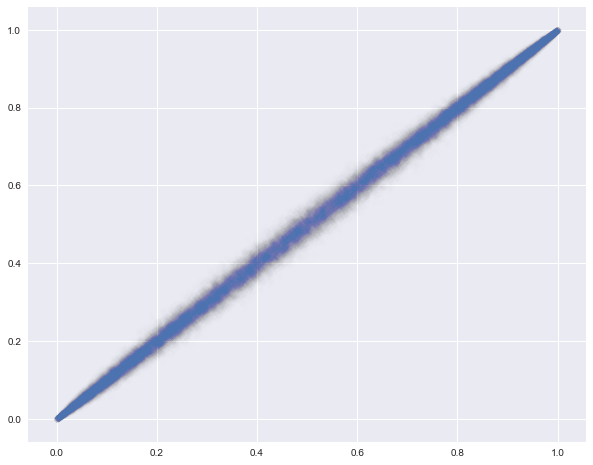

In [38]:
pred24f = pd.read_csv("./result/submission-024-first.csv")
pred31s0 = pd.read_csv("./result/submission-031-lgb-seed-0.csv")

plt.figure(figsize=(10, 8))
plt.scatter(pred24f.TARGET, pred31s0.TARGET, alpha=.005)
plt.show()

## blend

In [130]:
pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
pred_lgb024 = pd.read_csv("./result/submission-024-first.csv")
pred_lgbavg = pd.read_csv("./result/submission-030-bld-to-overfit.csv")
pred_keras025 = pd.read_csv("./result/submission-025-keras01.csv")
pred_bld = pd.read_csv("./result/submission-022-blend08.csv")
pred_keras_avg = pd.read_csv("./result/submission-030-keras01-avg-025.csv")

pred_sample["TARGET"] = calculate_rank(pred_lgbavg.TARGET) * 0.8 + calculate_rank(pred_bld.TARGET) * 0.15 + calculate_rank(pred_keras_avg.TARGET) * 0.05
pred_sample.to_csv("./result/submission-031-bld-to-overfit.csv", index=False)

In [131]:
pred_sample = pd.read_csv("./result/submission-022-blend08.csv")
pred_lgb024 = pd.read_csv("./result/submission-024-first.csv")
pred_lgbavg = pd.read_csv("./result/submission-030-bld-to-overfit.csv")
pred_keras025 = pd.read_csv("./result/submission-025-keras01.csv")
pred_bld = pd.read_csv("./result/submission-022-blend08.csv")
pred_keras_avg = pd.read_csv("./result/submission-030-keras01-avg-025.csv")

pred_sample["TARGET"] = calculate_rank(pred_lgbavg.TARGET) * 0.75 + calculate_rank(pred_bld.TARGET) * 0.15 + calculate_rank(pred_keras_avg.TARGET) * 0.1
pred_sample.to_csv("./result/submission-031-bld-to-overfit75.csv", index=False)